# How strong is Werder really?    *Or: A hierarchical probabilistic model to assess indivual team strength*

I am a big football fan, actually mostly a Werder Bremen supporter. Luckily, after some difficult years of hardship after their succesfull 2000s seasons, Werder has risen again under the guidance of their young and brilliant head coach Florian Kohfeldt and strategic manager - and Werder legend - Frank Baumann. So, when Kohfeldt took over in the middle of last season Werder started to play defensively strong but also tried to attack again, finally finalizing short of a place in the top third. This season with some key transfers the team is playing even more dominant and secured a place at the top of the league. However, this season the team's schedule of matches seems to be nicer than last seasons. First matches were against teams expected to rank low in the league and teams like Bayern Munich and Borussia Dortmund are played only at the end of the half-season. So, after seven games it is difficult to say how strong Werder actually is.

In football - here, I mean european football - statistics are not so widespread because there are less standardized situations. To analyze a general strength value, one needs to take every team's strength into account because a distinct team's strength is in the first approximation always relative to all of the other teams.

Therefore, a hierarchical probabilistic model has been used previously [1,2], where every team has latent variables for their attacking and defensive strength. Then, the scored goals are assumed to be distributed by a Binomial distribution depending on the difference of the opponents attacking and defensive strength. With this simple model every team can be analyzed based on all played games.

[1] Baio and Blangiardo, Journal of Applied Statistics 37 Issue 2 (2010) https://doi.org/10.1080/02664760802684177
<br>[2] Tsokos, A., Narayanan, S., Kosmidis, I. et al. Mach Learn (2018) https://doi.org/10.1007/s10994-018-5741-1 

## Import data
First, let's import all necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import math
%matplotlib inline

The data of the last seasons and this season of the Bundesliga and most other major leagues can be found as csv on http://www.football-data.co.uk/germanym.php . The files contain more data also on shots and corners for example but here we are only interested in the scored goals, called 'FTHG' and 'FTAG'.

In [2]:
goals_df = pd.read_csv('D1_2018_2019_incl.csv', usecols=['Date','HomeTeam','AwayTeam','FTHG','FTAG'])

All team names 'HomeTeam' and 'AwayTeam' are given as strings and need to be converted to a team index for numerical handling.

In [4]:
team_names = goals_df['HomeTeam'].unique()  #generate list of all unique team names
team_index = list(range(0,len(team_names)))    #generate list of indices of suitable range
teams_dict = dict(zip(team_names,team_index))  #generate a dictionary of indices and team names

def team_lookup(name):                         #lookup the index for a specific team name
    index = teams_dict[name]
    return index

In [5]:
goals_ind_df = goals_df.copy()
goals_ind_df['HomeTeam'] = goals_df['HomeTeam'].apply(team_lookup)  #apply the lookup on the home team names
goals_ind_df['AwayTeam'] = goals_df['AwayTeam'].apply(team_lookup)  #apply the lookup on the away team names

Now we have a dataframe that has all games with indices for the teams and scored goals, ready to be analyzed.

In [6]:
num_teams = len(team_names)
num_games = len(goals_ind_df)
goals_ind_df.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG
0,24/08/18,0,12,3,1
1,25/08/18,1,10,1,2
2,25/08/18,2,11,0,2
3,25/08/18,3,14,1,0
4,25/08/18,4,13,2,0


For later use we transform the columns into single lists.

In [7]:
team_home=goals_ind_df['HomeTeam'].values
team_away=goals_ind_df['AwayTeam'].values
score_home=goals_ind_df['FTHG'].values
score_away=goals_ind_df['FTAG'].values

## Probabilistic hierarchical model

The dataframe contains now the number of goals scored by the home (FTHG) and away team (FTAG) for the gth (index) match. FTHG and FTAG are assumed to be realizations of conditionally independent random variables $Y_{g,H}$ and $Y_{g,A}$ [1] that depend on the game-specific parameter $\Theta_{g,(H,A)}$.
<br><br>$y_{g,(H,A)} | \Theta_{g,(H,A)} \sim Poisson(\Theta_{g,(H,A)})$
<br> <br>The game-specific values for $\Theta$ are calculated with a log-linear random effect model that is widely used in statistical literature:
<br><br> $log(\Theta_{g,H}) = home + att_{H(g)} - defe_{A(g)}$
<br><br> $log(\Theta_{g,A}) = att_{A(g)} - defe_{H(g)}$
<br><br> Here, I changed the formulation to a minus to define defensive strength as highly positive values. The variable $Home$ reflects a possible home-field advantage. This probabilistic model focuses on the latent variables $att$ and $defe$ for every teams which are generated from common normal distributions with parameters $\mu_{att,defe}$ and $\tau_{att,defe}$. Therefore, such models are called hierarchical.

To infer the parameter distributions from existing data we use the Markov Chain Monte Carlo. In this method, the posterior distribution of the random variables is sampled over a large parameter space in form of a Markov Chain. To resemble the posterior distribution a acceptance rate is calculated for every new sample, which compares the likelihood and prior of the proposed parameters with the last set. If the acceptance rate is high, then the proposed parameters are accepted as a new sample with higher probability [3]. 
<br>Here, I used PyMC3 [https://docs.pymc.io] as a user-friendly library to efficiently do the sampling. A model is defined in a `with` statement by defining the priors and likelihood as given by distributions.

[3] see Bishop "Pattern Recognition and machine learning" for more details

In [8]:
with pm.Model() as model:
    #Define prior distributions
    mu_att = 0
    mu_defe = 0
    tau_att = pm.Gamma('tau_att', alpha=0.1, beta=0.1)
    tau_defe = pm.Gamma('tau_defe', alpha=0.1, beta=0.1)
    home = pm.Normal('home', mu=0, tau=0.0001)
    #Calculate latent variables
    att_prime = pm.Normal('att_prime', mu=mu_att, tau=tau_att, shape=num_teams)
    defe_prime = pm.Normal('defe_prime', mu=mu_defe, tau=tau_defe, shape=num_teams)
    #Normalize the att and defe
    att = pm.Deterministic('att', att_prime - att_prime.mean())
    defe = pm.Deterministic('defe', defe_prime - defe_prime.mean())
    #Calculate game-specific theta values as list
    theta_H_ls = np.exp(home + att[team_home] - defe[team_away])
    theta_A_ls = np.exp(att[team_away] - defe[team_home])
    #Define Likelihood
    y_H = pm.Poisson('y_H', theta_H_ls, observed=score_home)
    y_A = pm.Poisson('y_A', theta_A_ls, observed=score_away)

Here, I assumed that $\mu_{att,defe}$ are zero as this makes much sense with the normalization that is necessary to compare results from different runs. Also, normally distributed $\mu$s resulted in divergences of the parameters during sampling. The $\tau$ parameters are assumed to result from a broad Gamma distribution and the 'home' parameter from a broad Normal distribution.
<br>The parameters $att$ and $defe$ are determined by a Normal distribution. By setting `shape` to `num_teams` we obtain a vector with parameters for every team. The already adressed constraint that the sum of attacking and defending parameters is zero is necessary to be able to compare results from different sampling runs and leagues. Therefore, the obtained values are normalized by subtracting the mean value. Then the values for theta are calculated for every team and match as a list using Numpy's exponential function.
<br>Finally, the likelihood for the theta values and scored goals is calculated using the `observed` key, completing the model.

## Sampling

The defined model is sampled also within a `with` statement and the number of samples is given (20000).

In [9]:
with model:
    trace = pm.sample(20000, tune=500, init='adapt_diag')#, nuts_kwargs=dict(target_accept=.90))

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [defe_prime, att_prime, home, tau_defe, tau_att]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:18<00:00, 520.36draws/s]
/Users/hannokupers/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


The `trace` object contains the information of the sample run. The summary shows that the Gelman-Rubin parameter `Rhat` is close to 1.0 for all variables, indicating convergence of the sampling.

In [10]:
pm.summary(trace)

/Users/hannokupers/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
home,0.462932,0.094487,0.000498,0.280045,0.650954,36621.077372,0.999976
att_prime__0,0.185565,0.256689,0.001455,-0.318361,0.698809,30305.910514,0.999987
att_prime__1,-0.409911,0.305640,0.001720,-1.027119,0.175138,33944.814807,1.000027
att_prime__2,-0.122209,0.273896,0.001524,-0.672112,0.404950,36935.241586,0.999975
att_prime__3,0.083672,0.263890,0.001313,-0.427566,0.612072,32867.612406,1.000001
att_prime__4,0.418676,0.252472,0.001471,-0.060836,0.931750,26138.938378,1.000031
att_prime__5,0.157872,0.255947,0.001311,-0.352351,0.647894,31796.844552,0.999990
att_prime__6,-0.035903,0.272655,0.001485,-0.570549,0.496859,36148.980494,1.000051
att_prime__7,0.697754,0.238160,0.001546,0.239262,1.170622,22561.212613,0.999975
att_prime__8,-0.593272,0.330694,0.002075,-1.251971,0.029299,26161.048693,1.000120


Also the plots of the sampled posteriors show that the two individual chains (blue and orange) result in comparable distributions, indicating convergence. The plot of the trace itself on the right side shows that the parameters have been sampled homogeneously. This was not the case when a Normal distribution was used as prior for $\mu_{att}$ and $\mu_{defe}$ as was proposed in [1]. For such a definition, `att_prime` and `defe_prime` were randomly varying during sampling as only their difference is important for the likelihood calculation. However, the normalization constraint for the parameters also makes it more meaningful with directly setting $\mu_{att}$ and $\mu_{defe}$ to zero, avoiding such divergence problems.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c35b7e2b0>,
      dtype=object)

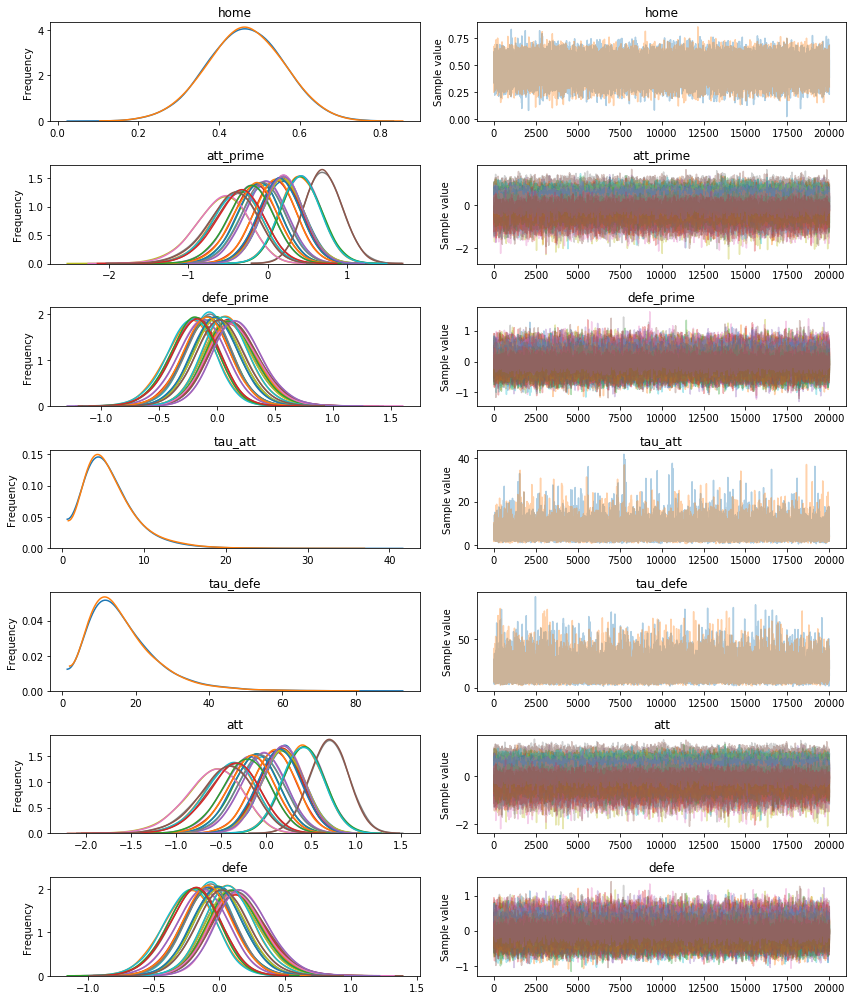

In [14]:
pm.traceplot(trace)

Another indicator for convergence is the plot of the mean parameter value over time. In the case of convergence, this parameter remains constant after convergence has been achieved:

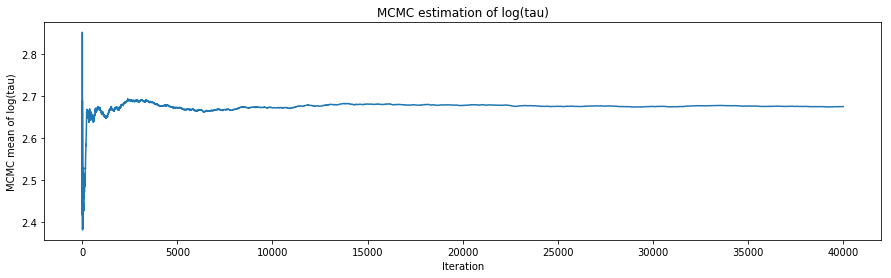

In [15]:
logtau = np.log(trace['tau_defe'])
mlogtau = [np.mean(logtau[:i]) for i in np.arange(1, len(logtau))]
plt.figure(figsize=(15, 4))
plt.plot(mlogtau)
plt.xlabel('Iteration')
plt.ylabel('MCMC mean of log(tau)')
plt.title('MCMC estimation of log(tau)');

## Visualization of results

Let's compare the values for the teams now and check how Werder ranks among the league's teams.

In [16]:
goals_for = np.zeros(num_teams)
goals_against = np.zeros(num_teams)

for index, row in goals_ind_df.iterrows():
    goals_for[row['HomeTeam']] += row['FTHG']
    goals_for[row['AwayTeam']] += row['FTAG']
    goals_against[row['HomeTeam']] += row['FTAG']
    goals_against[row['AwayTeam']] += row['FTHG']

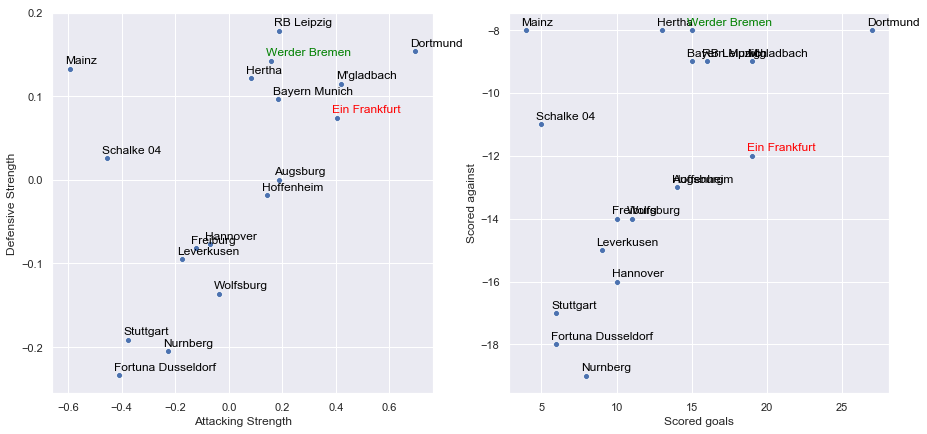

In [22]:
sns.set()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7))
sns.scatterplot(x=trace.get_values('att').mean(axis=0), 
               y=trace.get_values('defe').mean(axis=0), ax=ax1)

ax1.set_xlabel('Attacking Strength')
ax1.set_ylabel('Defensive Strength')

for label, x, y in zip(team_names, trace.get_values('att').mean(axis=0), trace.get_values('defe').mean(axis=0)):
    if label == 'Werder Bremen':
        clr = 'green'
    elif label == 'Ein Frankfurt':
        clr = 'red'
    else:
        clr = 'black'
    ax1.annotate(label, xy=(x,y), xytext = (-5,5), textcoords = 'offset points', color=clr)
    
sns.scatterplot(x=goals_for, y=-goals_against, ax=ax2)

ax2.set_xlabel('Scored goals')
ax2.set_ylabel('Scored against')

for label, x, y in zip(team_names, goals_for, -goals_against):
    if label == 'Werder Bremen':
        clr = 'green'
    elif label == 'Ein Frankfurt':
        clr = 'red'
    else:
        clr = 'black'
    ax2.annotate(label, xy=(x,y), xytext = (-5,5), textcoords = 'offset points', color=clr)

The plot on the left shows the extracted parameters for all teams. Teams with good attacking and defending strength are located in the upper right corner. Also, Werder is among those teams showing that their success might be substantial. The plot on the rigth shows the scored goals for and against all teams. This is in principle the data basis for the probabilistic model. When the two plots are compared a quite similar distribution of teams in the parameter space is seen. Only some interesting differences appear, such as That Eintracht Frankfurt for example is ranked with a higher defensive strength in our model than observed from only the conceived goals. Probably, Frankfurt played against teams with strong offense such as Gladbach and Dortmund, challenging their defensive strength.
<br> A central advantage of such a Bayesian model is that we not only obtain the maximum value of the posterior but the complete distribution, showing us a measure for how sure we can be of the obtained parameters. The following plot shows the obtained values for the 'att' variables and their 95% confidence interval. These confidence intervals overlap largely for the parameters of the different teams, meaning that we cannot be so sure about the obtained parameters. This low confidence is due to the small amount of matches that are analyzed, where every game only happens once and is not repeated to generate better statistics. Unfortunately, this result also limits the possibility of using the model for predictions of future matches.

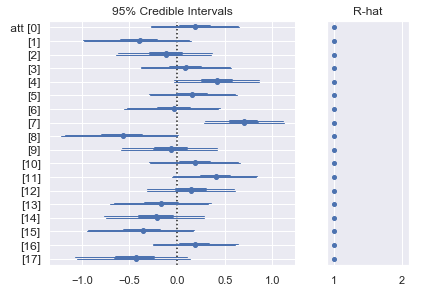

In [23]:
pm.forestplot(trace, varnames=['att']);

### Home advantage

An interesting parameter of the hierarchical model is the home strength, which makes it richer than only looking at the scored goals. The existence of such a home-field advantage for the number of scored goals has been observed in many studies [4]. We obtained a mean value of 0.46, meaning that the expected amount of goals scored at home is 58% higher than away.
<br><br>[4] Jacklin, Journal of Sports Sciences Volume 23, 2005 - Issue 7, 669-679, https://doi.org/10.1080/02640410400021948

## Summary

The results show that Werder Bremen has good offensive and defensive strength. However, due to the small amount of data, the sampled posteriors are broad and their predictive power is limited. The hierarchical Bayesian model is a nice example of latent variables such as the attacking and defensive strength as invisible parameters that are underlying these processes. Also PyMC3 showed to be a convenient framework to do MCMC sampling and also comes with some easy to use visualization tools for checking the convergence.